### Complejidad - Práctico 4/6 - Generación procedural de terrenos
#### Lautaro Giordano

In [23]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import linregress

In [86]:
class cueva:
    def __init__(self, width, height, prob_pared, prob_cambio, seed=None):
        self.width = width
        self.height = height
        self.prob_pared = prob_pared
        # El default es seed=None que me da una semilla aleatoria.
        self.seed = seed
        np.random.seed(self.seed)
        self.cueva = self.generar_cueva()
        self.bordes = self.calcular_bordes()
        self.p_cambio = prob_cambio
    

    def generar_cueva(self):
        cueva = np.ones((self.height, self.width))

        # Los bordes siempre son unos (paredes).
        for i in range(1, self.height - 1):
            for j in range(1, self.width - 1):
                cueva[i][j] = 1 if np.random.random() < self.prob_pared else 0
        
        return cueva

    
    def calcular_bordes(self):
        bordes = np.zeros((self.height, self.width))
        valor_borde = 1

        for i in range(1, self.height - 1):
            for j in range(1, self.width - 1):
                # Si la celda actual no es una pared, no forma parte del borde
                if self.cueva[i][j] == 0:
                    continue
                # Chequeo si las paredes del rectangulo son parte del borde
                elif i == 0:
                    if self.cueva[i+1][j] == 0:
                        bordes[i][j] = valor_borde
                elif i == self.height - 1:
                    if self.cueva[i-1][j] == 0:
                        bordes[i][j] = valor_borde 
                elif j == 0: 
                    if self.cueva[i][j+1] == 0:
                        bordes[i][j] = valor_borde
                elif j == self.width - 1:
                    if self.cueva[i][j-1] == 0:
                        bordes[i][j] = valor_borde
                
                else:
                    # Miro a primeros vecinos de una celda
                    # Si hay algún vecino que no es una pared, la celda actual es un borde
                    if self.cueva[i+1][j] == 0 or self.cueva[i-1][j] == 0 or self.cueva[i][j+1] == 0 or self.cueva[i][j-1] == 0:
                        bordes[i][j] = valor_borde
        return bordes
       

    def plot_cueva(self, bordes=False):
        combined = self.cueva.copy()
        escala = 1 / 50

        fig, ax = plt.subplots(figsize=(self.width * escala, self.height * escala))

        if bordes:
            self.bordes = self.calcular_bordes()
            combined[self.bordes == 1] = 2  # Pared que es borde

            # Defino el mapa de colores: 0 = blanco, 1 = negro, 2 = rojo
            cmap = mcolors.ListedColormap(['white', 'black', 'red'])

        else:
            cmap = mcolors.ListedColormap(['white', 'black'])

        ax.imshow(combined, cmap=cmap)
        
        ax.axis('off')
        plt.show()

    def plot_borde(self):
        escala = 1 / 50

        fig, ax = plt.subplots(figsize=(self.width * escala, self.height * escala))
        ax.imshow(self.bordes, cmap='Reds')
        ax.axis('off')

        plt.show()

    def paso_suavizar_cueva(self):
        cueva = self.cueva.copy()
        # No miro los bordes
        for i in range(1, self.height - 1):
            for j in range(1, self.width - 1):
                # Miro a primeros vecinos de una celda
                vecindad = cueva[i-1:i+2, j-1:j+2]
                # Si hay más de 5 celdas con pared, pongo una pared (regla del automata)
                if np.sum(vecindad) >= 5 and np.random.rand() < self.p_cambio:
                    self.cueva[i][j] = 1
                # Si hay menos de 3 celdas con pared, pongo un espacio vacío
                elif np.sum(vecindad) <= 3 and np.random.rand() < self.p_cambio:
                    self.cueva[i][j] = 0
                # Si hay 4 celdas con pared, dejo como está


    def suavizar_cueva(self, n_its=5):
        for _ in range(n_its):
            self.paso_suavizar_cueva()

In [21]:
# Hago box counting sobre los bordes
def box_counting(bordes, box_size):
    # Cuento cuántos cuadrados de tamaño box_size necesito para cubrir los bordes
    n_boxes_x = int(np.ceil(bordes.shape[1] / box_size))
    n_boxes_y = int(np.ceil(bordes.shape[0] / box_size))

    boxes = np.zeros((n_boxes_y, n_boxes_x))

    for i in range(n_boxes_y):
        for j in range(n_boxes_x):
            # Cuento cuántos bordes hay en el cuadrado
            box = bordes[i*box_size:(i+1)*box_size, j*box_size:(j+1)*box_size]
            boxes[i, j] = np.sum(box)

    return np.sum(boxes > 0)

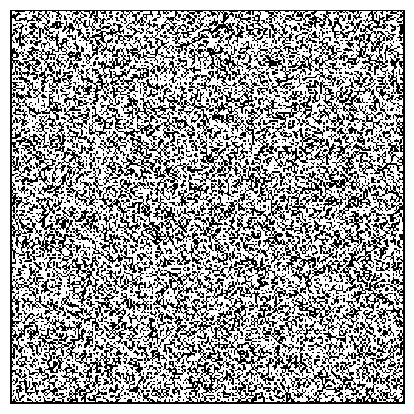

In [87]:
width, height = 256, 256

cuevas = cueva(width, height, prob_pared=0.4, prob_cambio=.7, seed=1)
cuevas.plot_cueva(bordes=False)
cuevas.suavizar_cueva(50)

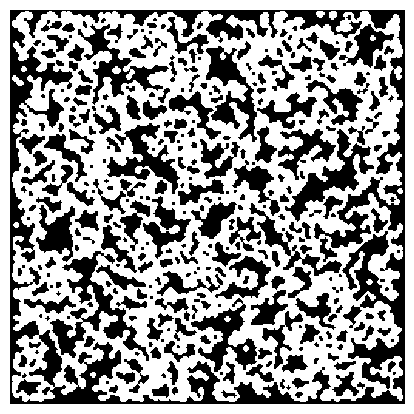

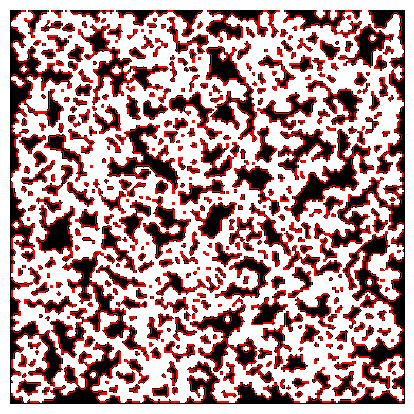

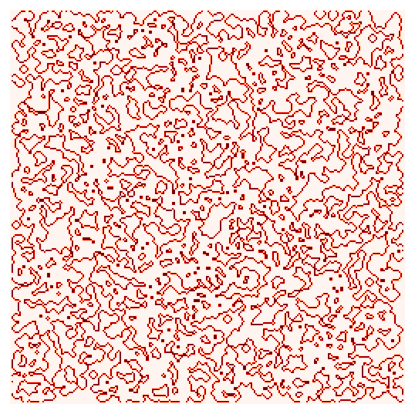

% del borde: 18.82%


In [88]:
cuevas.plot_cueva()
cuevas.plot_cueva(bordes=True)
cuevas.plot_borde()
print(f"% del borde: {np.sum(cuevas.bordes) / (width * height) * 100:.2f}%")
# fig, ax = plt.subplots(figsize=(10, 10))
# ax.imshow(cueva.cueva[-20:120][-20:120], cmap='binary')

In [90]:
proporcion_borde = []

for size in [32, 64, 128, 256]:
    cuevas = cueva(size, size, 0.4, prob_cambio=.7, seed=1)
    cuevas.suavizar_cueva(50)
    borde = cuevas.calcular_bordes()
    proporcion_borde.append(np.sum(borde) / (size * size) * 100)
    print(f"% del borde para cueva de {size}x{size}: {proporcion_borde[-1]}%")

% del borde para cueva de 32x32: 17.1875%
% del borde para cueva de 64x64: 16.9189453125%
% del borde para cueva de 128x128: 18.109130859375%
% del borde para cueva de 256x256: 18.82171630859375%


Dimension fractal: 1.84 +- 0.04


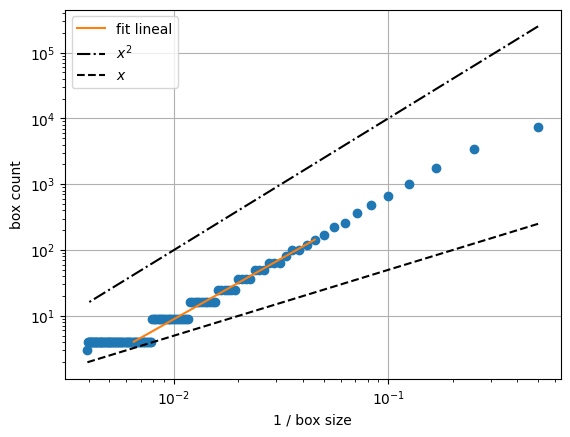

In [89]:
# Ahora quiero hacer box counting sobre los bordes y estimar su dimension fractal
# Para eso, primero necesito encontrar los bordes de la cueva
# Luego, hago un box counting sobre los bordes
# Finalmente, hago un ajuste lineal para encontrar la dimensión fractal

# Encuentro los bordes de la cueva
bordes = cuevas.calcular_bordes()

In [20]:


box_sizes = np.arange(2, cuevas.height, 2)
inverse_box_sizes = 1 / np.array(box_sizes)
box_counts = [box_counting(bordes, box_size) for box_size in box_sizes]

plt.plot(inverse_box_sizes, box_counts, 'o')
plt.xscale('log')
plt.yscale('log')
plt.grid()


# Fiteo solo una zona
sliced_inverse_size = inverse_box_sizes[10:-50]
sliced_box_count = box_counts[10:-50]

slope, intercept, _, _, std_err = linregress(np.log(sliced_inverse_size), np.log(sliced_box_count))
plt.plot(sliced_inverse_size, np.exp(intercept) * sliced_inverse_size**slope, label=f'fit lineal')

# Ploteo x^2
plt.plot(inverse_box_sizes,1e6 * inverse_box_sizes**2, 'k-.', label=r'$x^2$')
plt.plot(inverse_box_sizes,5e2 * inverse_box_sizes, 'k--', label=r'$x$')

plt.xlabel('1 / box size')
plt.ylabel('box count')
plt.legend()

print(f'Dimension fractal: {slope:.2f} +- {std_err:.2f}')


plt.show()

NameError: name 'cuevas' is not defined

C:\Users\Lautaro\AppData\Local\Temp\ipykernel_9044\2959602563.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


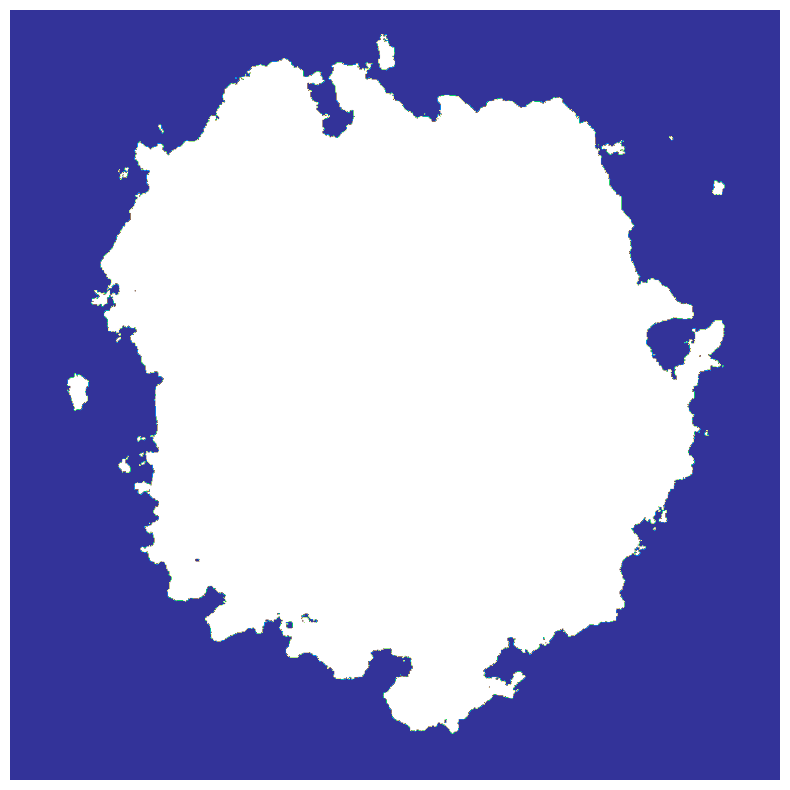

In [319]:
import noise  # Perlin noise library


# Create a circular gradient with noise
def generate_island_grid(grid_size, radius):
    grid = np.zeros((grid_size, grid_size))
    center_x, center_y = grid_size // 2, grid_size // 2
    for x in range(grid_size):
        for y in range(grid_size):
            # Distance from center
            dx = (x - center_x) / radius
            dy = (y - center_y) / radius
            distance = np.sqrt(dx**2 + dy**2)
            
            # Base land shape: higher probability of land near the center
            land_probability = max(0, 1 - distance)
            
            # Add some Perlin noise to roughen the island's shape
            x_norm, y_norm = x / grid_size, y / grid_size
            noise_value1 = noise.pnoise2(x_norm, y_norm, octaves=16)
            noise_value2 = noise.pnoise2(4 * x_norm, 4 * y_norm, octaves=16)
            noise_value3 = noise.pnoise2(8 * x_norm, 8 * y_norm, octaves=16)
            noise_value4 = noise.pnoise2(16 * x_norm, 16 * y_norm, octaves=16)
            noise_value = .5 * noise_value1 + .25 * noise_value2 + .15 * noise_value3 + .1 * noise_value4

            final_value = land_probability + 0.7 * noise_value
            
            # Threshold to define land or water
            grid[x, y] = 1 if final_value > 0.5 else 0
    
    return grid

# Generate an island grid and plot
grid_size = 1024
island_grid = generate_island_grid(grid_size, radius=(.8*grid_size))
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(island_grid, cmap="terrain")
ax.axis('off')
fig.show()

In [320]:
grid = island_grid


def calcular_bordes(grid):
        bordes = np.zeros((grid_size, grid_size))
        valor_borde = 1

        for i in range(1, grid_size - 1):
            for j in range(1, grid_size - 1):
                # Si la celda actual no es una pared, no forma parte del borde
                if grid[i][j] == 0:
                    continue
                # Chequeo si las paredes del rectangulo son parte del borde
                elif i == 0:
                    if grid[i+1][j] == 0:
                        bordes[i][j] = valor_borde
                elif i == grid_size - 1:
                    if grid[i-1][j] == 0:
                        bordes[i][j] = valor_borde 
                elif j == 0: 
                    if grid[i][j+1] == 0:
                        bordes[i][j] = valor_borde
                elif j == grid_size - 1:
                    if grid[i][j-1] == 0:
                        bordes[i][j] = valor_borde
                
                else:
                    # Miro a primeros vecinos de una celda
                    # Si hay algún vecino que no es una pared, la celda actual es un borde
                    if grid[i+1][j] == 0 or grid[i-1][j] == 0 or grid[i][j+1] == 0 or grid[i][j-1] == 0:
                        bordes[i][j] = valor_borde
        return bordes

In [321]:
bordes = calcular_bordes(grid)

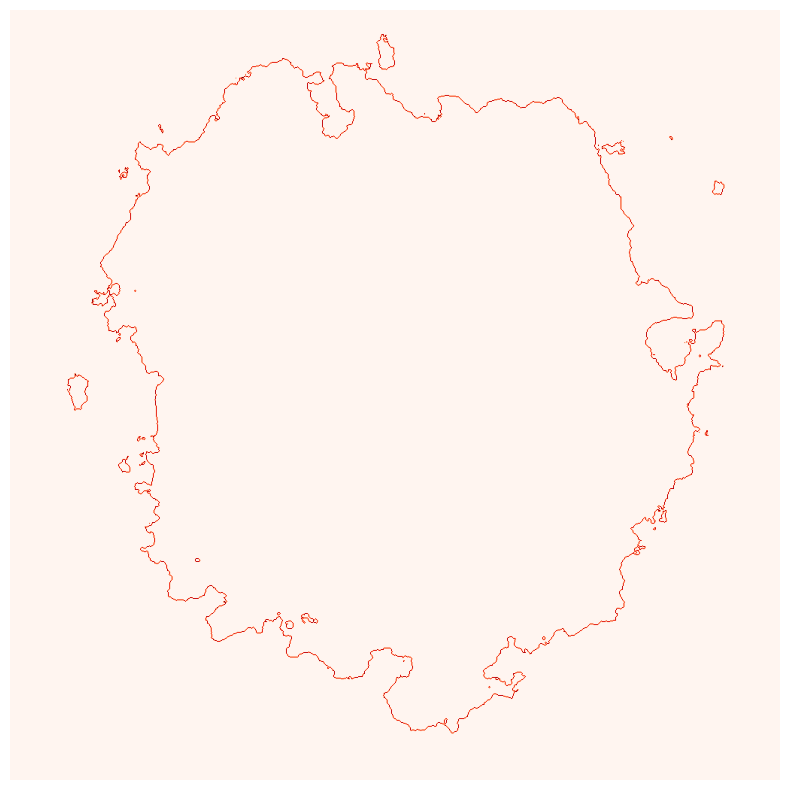

In [331]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(bordes, cmap='Reds')
ax.axis('off')
plt.show()

Dimension fractal: 1.18 +- 0.02


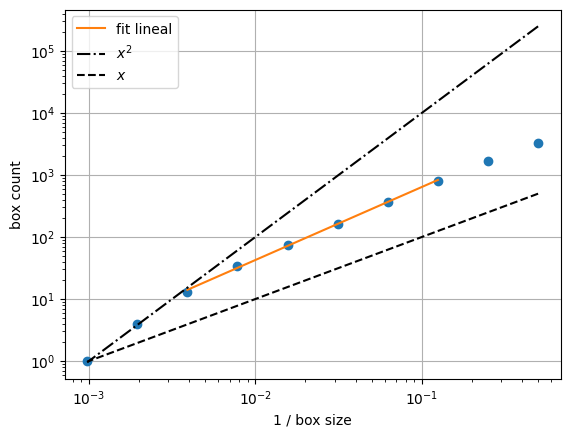

In [327]:
box_sizes = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
inverse_box_sizes = 1 / np.array(box_sizes)
# bordes[bordes>0]
box_counts = [box_counting(bordes, box_size) for box_size in box_sizes]

plt.plot(inverse_box_sizes, box_counts, 'o')
plt.xscale('log')
plt.yscale('log')
plt.grid()

# Fiteo solo una zona
sliced_inverse_size = inverse_box_sizes[2:-2]
sliced_box_count = box_counts[2:-2]

slope, intercept, _, _, std_err = linregress(np.log(sliced_inverse_size), np.log(sliced_box_count))
plt.plot(sliced_inverse_size, np.exp(intercept) * sliced_inverse_size**slope, label=f'fit lineal')

# Ploteo x^2
plt.plot(inverse_box_sizes, 1e6 * inverse_box_sizes**2, 'k-.', label=r'$x^2$')
plt.plot(inverse_box_sizes, 1e3 * inverse_box_sizes, 'k--', label=r'$x$')

plt.xlabel('1 / box size')
plt.ylabel('box count')
plt.legend()

print(f'Dimension fractal: {slope:.2f} +- {std_err:.2f}')


plt.show()